In [1]:
# Adapted from https://github.com/yalsayyad/dm_notebooks/blob/master/examples/ComputationalPerf.ipynb

In [1]:
from lsst.daf.butler import Butler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
butler = Butler('/sps/lsst/users/leboulch/test_DRP_optim/ci_hsc_gen3/DATA', collections=['HSC/runs/ci_hsc_resource_usage/20230731T154501Z'])

In [3]:
res = butler.registry.queryDatasetTypes()
resList = list(set(res))
[r.name for r in resList if r.name.endswith('usage')]

['match_astromRefCat_visit_resource_usage',
 'forcedPhotCoadd_resource_usage',
 'makeVisitTable_resource_usage',
 'plot_ellipResids_quiver_visit_resource_usage',
 'subtractImages_resource_usage',
 'detectAndMeasureDiaSources_resource_usage',
 'plot_E2Diff_scatter_resource_usage',
 'characterizeImage_resource_usage',
 'calibrate_resource_usage',
 'plot_CircAp12_sub_PSF_meas_sky_gals_visit_resource_usage',
 'plot_CircAp12_sub_PSF_meas_stars_scatter_resource_usage',
 'plot_CircAp12_sub_PSF_meas_gals_scatter_resource_usage',
 'analyzeObjectTableCore_resource_usage',
 'plot_CircAp12_sub_PSF_meas_sky_stars_resource_usage',
 'plot_CircAp25_sub_PSF_meas_scatter_visit_resource_usage',
 'writePreSourceTable_resource_usage',
 'plot_CModel_sub_PSFmag_meas_sky_galaxies_resource_usage',
 'plot_E1Diff_sky_resource_usage',
 'plot_CircAp12_sub_PSF_calib_psf_used_sky_unknown_visit_resource_usage',
 'measure_resource_usage',
 'forcedPhotDiffim_resource_usage',
 'getTemplate_resource_usage',
 'plot_astrom

In [4]:
quantileList = []
for rname in [r.name for r in resList if r.name.endswith('usage')]:
    parq = butler.get(rname)
    df = parq.quantile([0,0.01,0.05,.32,.50,.68,.95,.99, 1], numeric_only=True).reset_index()
    df['task'] = rname.replace('_resource_usage', '')
    df['quanta'] = len(parq)
    df['integrated_runtime'] = parq["run_time"].sum()
    quantileList.append(df[["index", "quanta", "task", "memory", "init_time", "run_time", 'integrated_runtime']])

In [44]:
qq = pd.concat(quantileList)
qq["memoryGB"] = qq['memory']/1073741824
qq['integrated_runtime_hrs'] = qq['integrated_runtime']/3600.
#pd.set_option('display.max_rows', 1200)
#qq

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2023_30/conda/envs/lsst-scipipe-7.0.1-exact/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


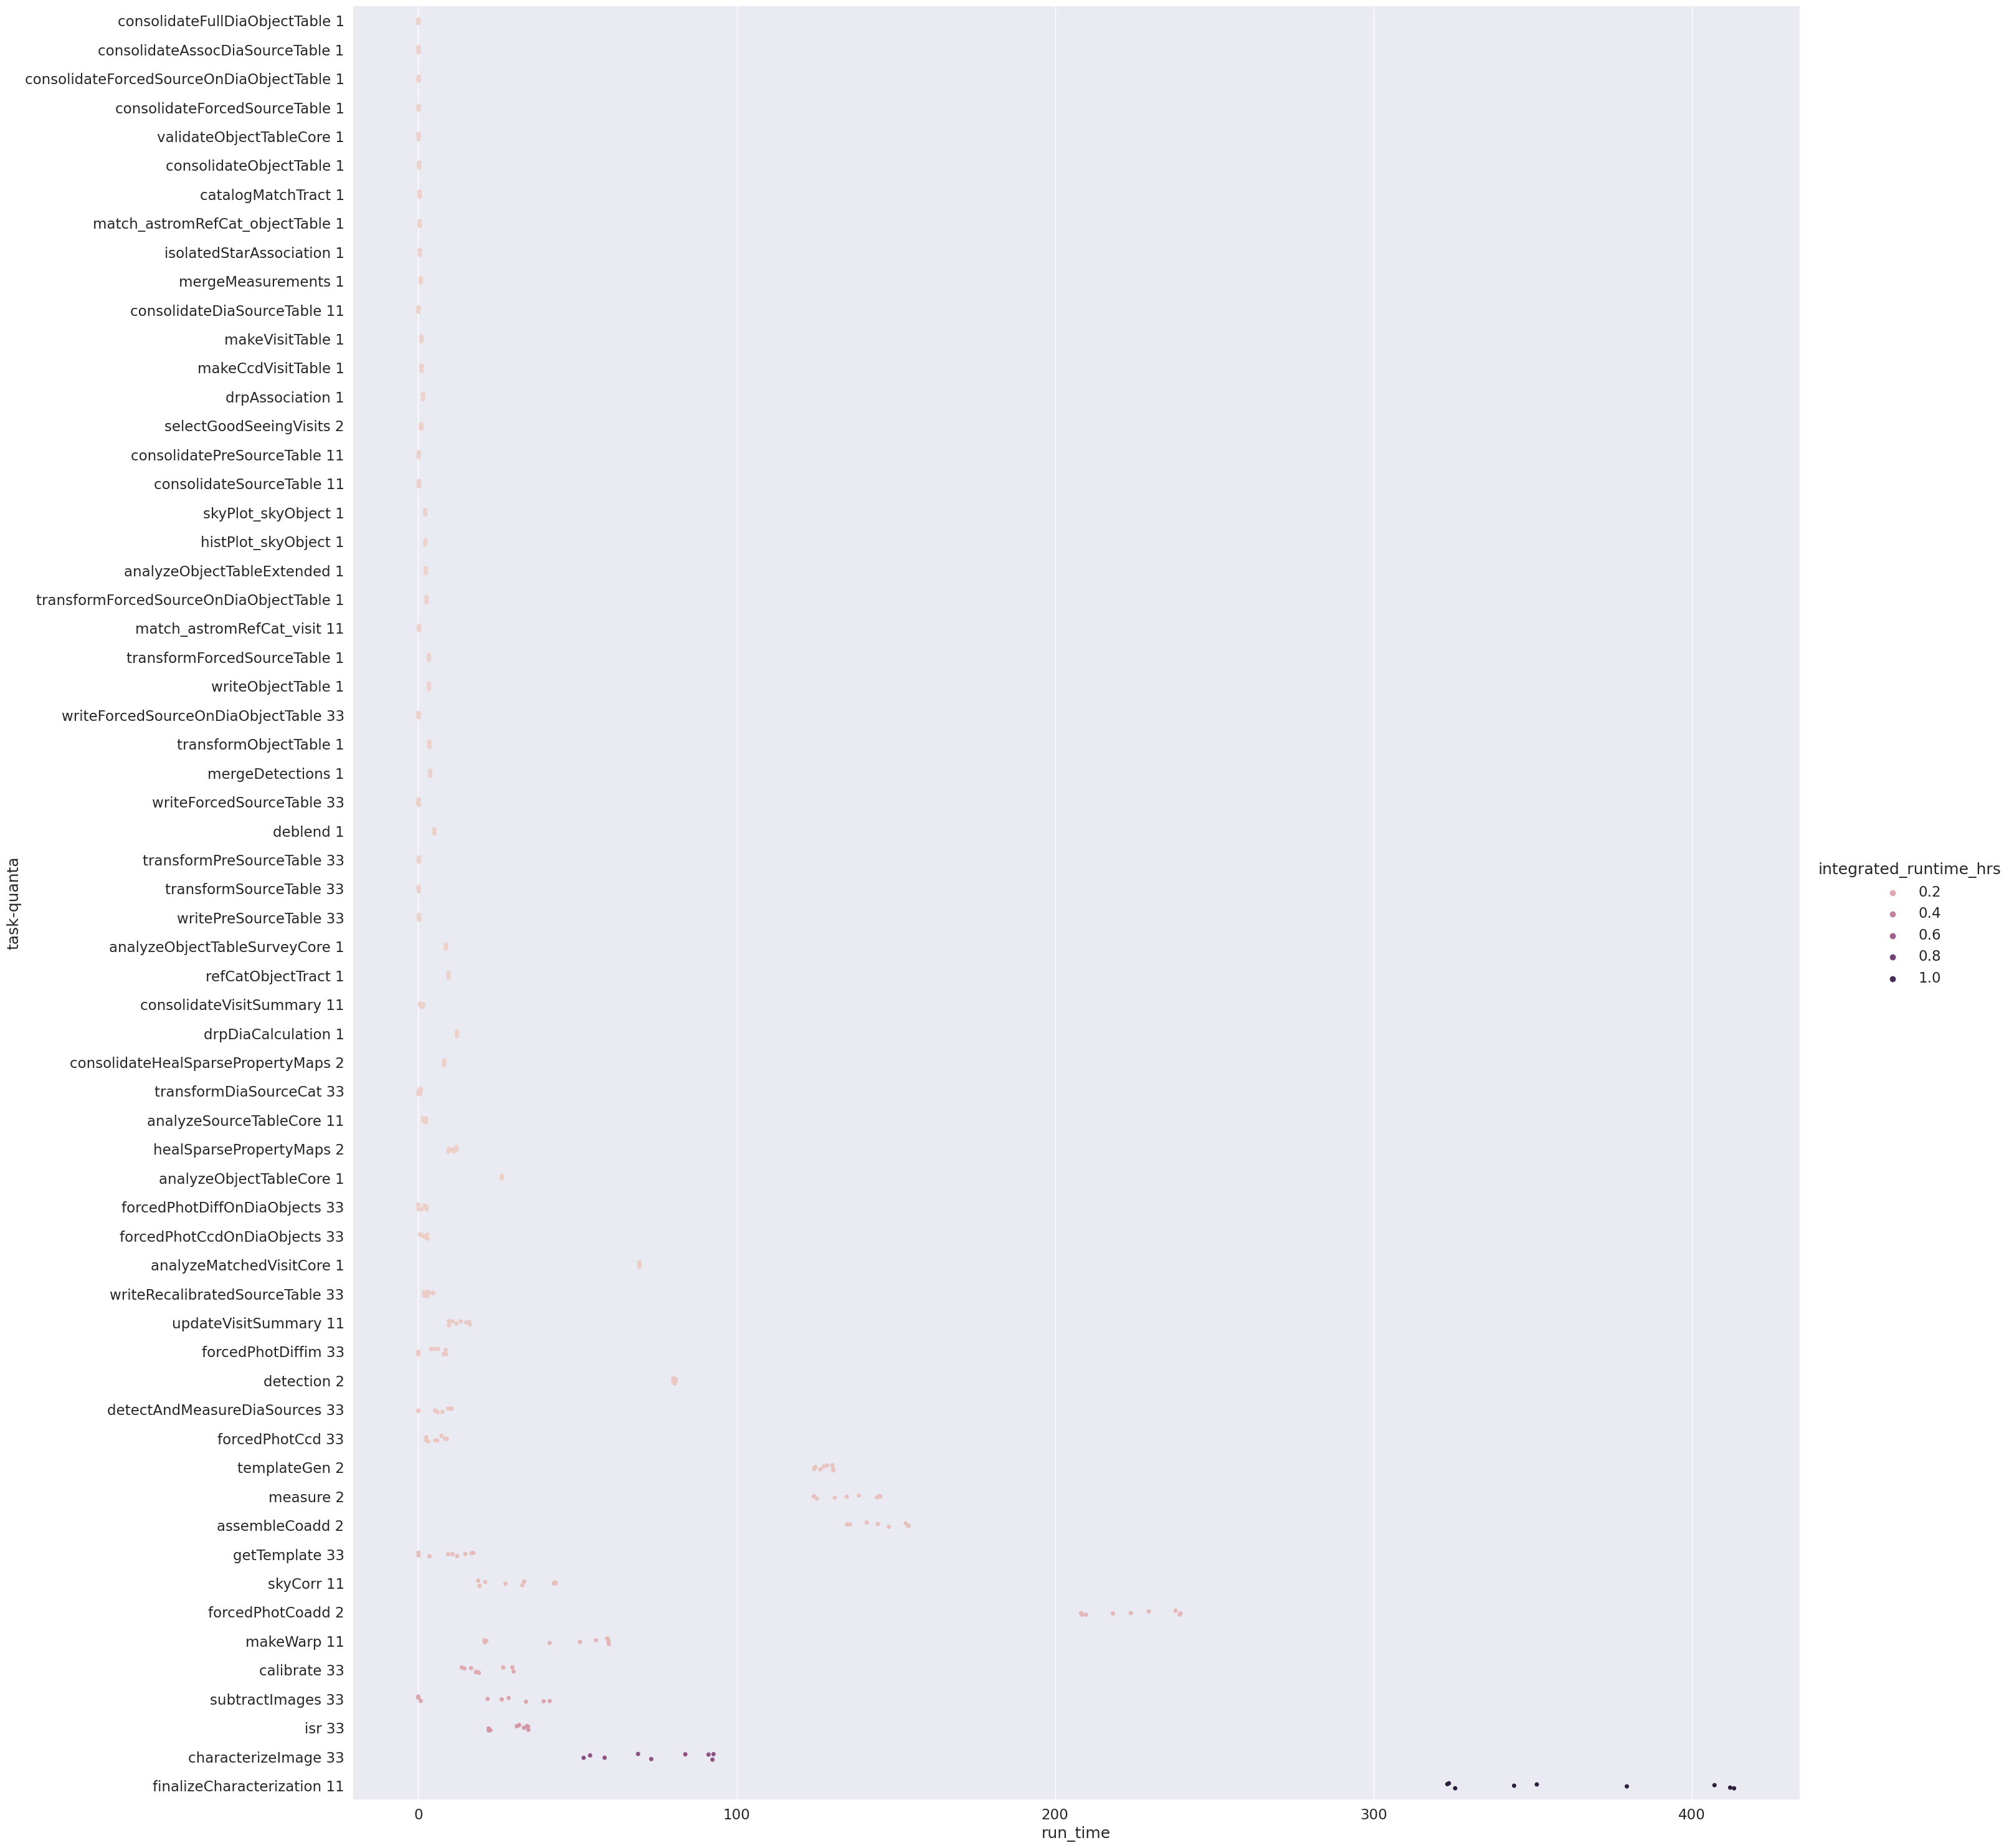

<Figure size 640x480 with 0 Axes>

In [45]:
qq['task-quanta'] = qq['task'] + ' ' + qq['quanta'].apply(lambda x: str(x))
ax = sns.catplot(data=qq[~qq.task.str.startswith("plot_")].sort_values('integrated_runtime_hrs'), y="task-quanta", x="run_time", hue="integrated_runtime_hrs", height=30)
plt.show()
#plt.savefig('runtime.png')

In [46]:
memoryGB = pd.pivot_table(qq, values='memoryGB', columns=['index'], index=['task'])
runtime = pd.pivot_table(qq, values='run_time', columns=['index'], index=['task'])
memoryGB = memoryGB.add_prefix('memGB_')
runtime = runtime.add_prefix('runtime_')

In [47]:
memrun = pd.merge(memoryGB.reset_index(), runtime.reset_index())
memrun = pd.merge(qq[['task','quanta', 'integrated_runtime_hrs']].drop_duplicates().sort_values('task'), memrun)

In [48]:
pd.set_option('display.max_rows', 150)
memrun

,task,quanta,integrated_runtime_hrs,memGB_0.0,memGB_0.01,memGB_0.05,memGB_0.32,memGB_0.5,memGB_0.68,memGB_0.95,...,memGB_1.0,runtime_0.0,runtime_0.01,runtime_0.05,runtime_0.32,runtime_0.5,runtime_0.68,runtime_0.95,runtime_0.99,runtime_1.0
0,analyzeMatchedVisitCore,1,0.019290,0.967670,0.967670,0.967670,0.967670,0.967670,0.967670,0.967670,...,0.967670,69.445402,69.445402,69.445402,69.445402,69.445402,69.445402,69.445402,69.445402,69.445402
1,analyzeObjectTableCore,1,0.007288,1.080414,1.080414,1.080414,1.080414,1.080414,1.080414,1.080414,...,1.080414,26.236953,26.236953,26.236953,26.236953,26.236953,26.236953,26.236953,26.236953,26.236953
2,analyzeObjectTableExtended,1,0.000645,0.590370,0.590370,0.590370,0.590370,0.590370,0.590370,0.590370,...,0.590370,2.322447,2.322447,2.322447,2.322447,2.322447,2.322447,2.322447,2.322447,2.322447
3,analyzeObjectTableSurveyCore,1,0.002387,0.623714,0.623714,0.623714,0.623714,0.623714,0.623714,0.623714,...,0.623714,8.592647,8.592647,8.592647,8.592647,8.592647,8.592647,8.592647,8.592647,8.592647
4,analyzeSourceTableCore,11,0.005677,0.553509,0.553524,0.553585,0.553757,0.554081,0.554213,0.554379,...,0.554428,1.542618,1.544955,1.554301,1.654089,1.780811,1.887476,2.351434,2.456225,2.482423
5,assembleCoadd,2,0.080182,2.532673,2.535563,2.547121,2.625144,2.677158,2.729173,2.807195,...,2.821644,134.619010,134.813191,135.589911,140.832777,144.328020,147.823263,153.066129,153.842849,154.037029
6,calibrate,33,0.177504,0.800278,0.800364,0.800610,0.801195,0.801491,0.801865,0.808340,...,0.824226,13.638718,14.501351,16.587587,18.098774,18.627811,18.997176,26.655148,29.528048,29.936908
7,catalogMatchTract,1,0.000120,0.531132,0.531132,0.531132,0.531132,0.531132,0.531132,0.531132,...,0.531132,0.432369,0.432369,0.432369,0.432369,0.432369,0.432369,0.432369,0.432369,0.432369
8,characterizeImage,33,0.692713,0.809113,0.809268,0.809654,0.810859,0.811390,0.812014,0.970206,...,1.093460,51.929891,53.954746,58.506587,69.016061,73.156452,83.851348,91.156547,92.376504,92.707005
9,consolidateAssocDiaSourceTable,1,0.000026,0.525696,0.525696,0.525696,0.525696,0.525696,0.525696,0.525696,...,0.525696,0.092620,0.092620,0.092620,0.092620,0.092620,0.092620,0.092620,0.092620,0.092620


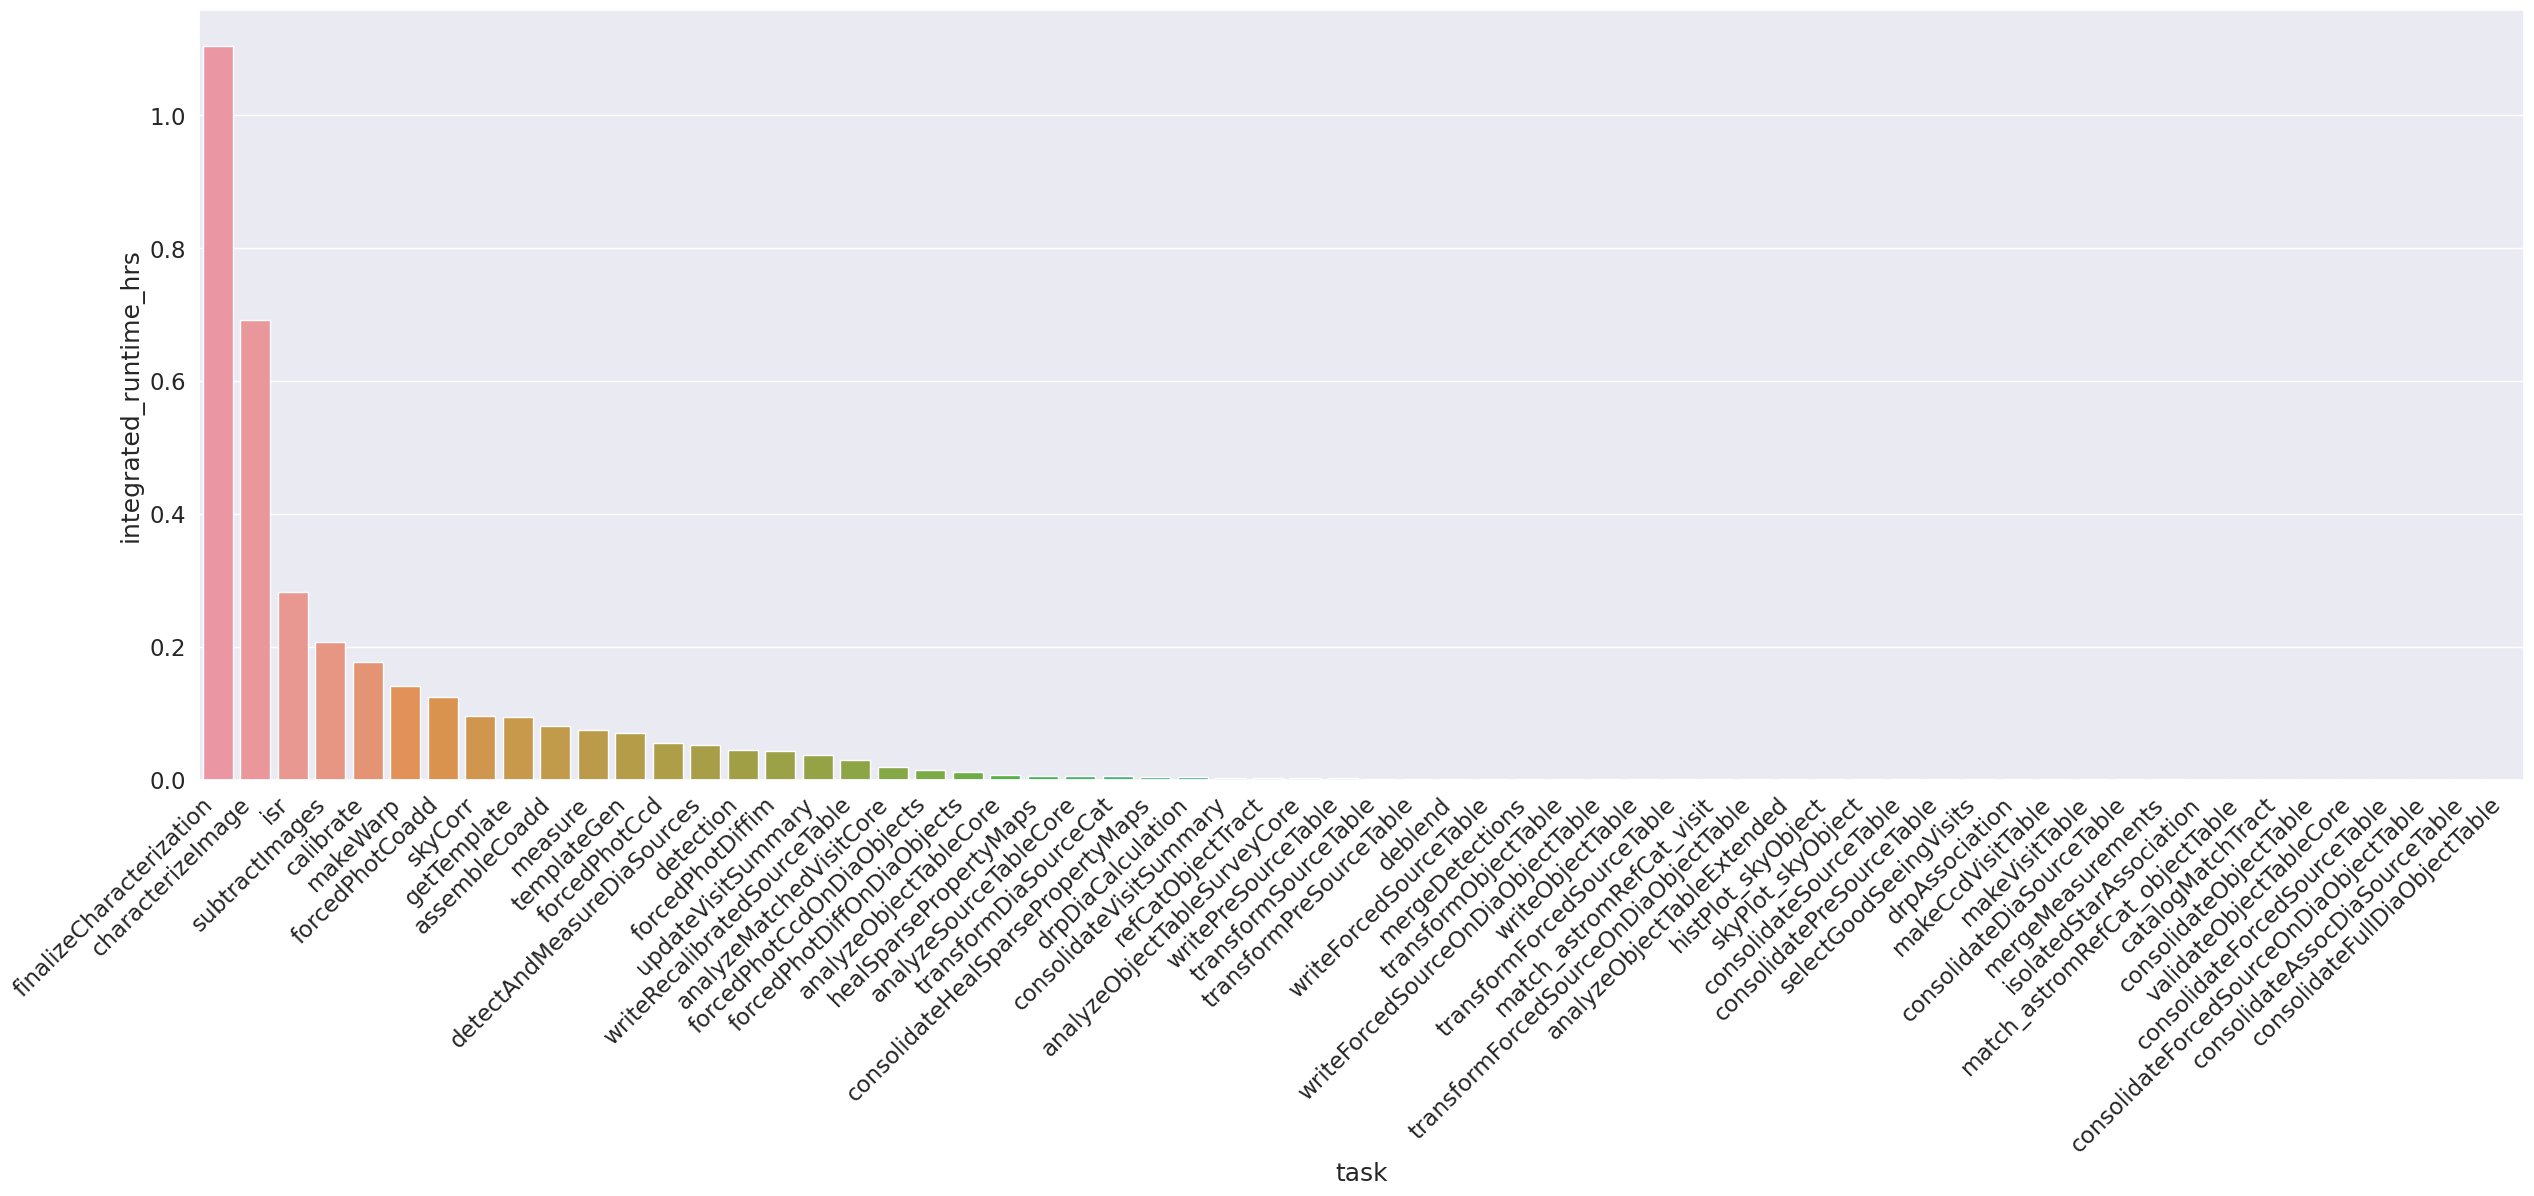

In [72]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.set(font_scale=1.5)
ax = sns.barplot(data=qq[~qq.task.str.startswith("plot_")].sort_values('integrated_runtime_hrs',ascending=False), y="integrated_runtime_hrs", x="task")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()